In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import msprime
import glob
import ast
from IPython.display import display,SVG
from scipy.stats import hmean

In [54]:
def get_pi(haplotypes):
    ## If no seg sites in a pop then haplotypes will be 0 length
    if haplotypes.size == 0:
        return 0
    n = len(haplotypes[0])
    n_comparisons = float(n) * (n - 1) / 2

    pi = 0
    for hap in haplotypes:
        k = np.count_nonzero(hap)
        pi += float(k) * (n - k) / n_comparisons
    return pi


def get_dxy(ihaps_t, mhaps_t):
    ## If no seg sites in a pop then haplotypes will be 0 length
    if ihaps_t.size == 0 or mhaps_t.size == 0:
        return 0

    ## Number of comparisons is == to n_island * n_metacommunity`
    ## n_metacommunity
    n_island = ihaps_t.shape[1]
    n_meta = mhaps_t.shape[1]
    n_comparisons = n_island * n_meta

    dxy = 0
    len_seq = ihaps_t.shape[0]

    ## ibases and mbases are now a list of all bases at a particular
    ## site within each population
    ## There's probably a more elegant way to do this but I was
    ## gunning for readibility. Probably failed.
    for ibases, mbases in zip(ihaps_t, mhaps_t):
        nonzeros_island = np.count_nonzero(ibases)
        nonzeros_meta = np.count_nonzero(mbases)
        zeros_island = n_island - nonzeros_island
        zeros_meta = n_meta - nonzeros_meta

        dxy += (nonzeros_island * zeros_meta \
                + zeros_island * nonzeros_meta) / float(n_comparisons)
    return dxy


def get_sumstats(ts, nsamps = 10):
    all_haps = ts.haplotypes()
    ## Get population specific haplotypes
    island_haps = [next(all_haps) for _ in range(nsamps)]
    meta_haps = [next(all_haps) for _ in range(nsamps)]

    ## Calculate S for each population
    ihaps_t = np.transpose(np.array([list(map(int, list(x))) for x in island_haps]))
    mhaps_t = np.transpose(np.array([list(map(int, list(x))) for x in meta_haps]))

    ## Counter makes a dict, so just get the counts for 2, which indicates 
    ## sites segregating in the pop
    ## S will not always == S_island + S_meta. If a site is fixed in one pop and not
    ## present in the other then S will be less than the total. If a site is segragating
    ## in both pops then S will be greater than the total.
    ## There's probably a smarter way to do this....
    S_island = collections.Counter([len(set(ihaps_t[x])) for x in range(len(ihaps_t))])[2]
    S_meta = collections.Counter([len(set(mhaps_t[x])) for x in range(len(mhaps_t))])[2]

    ## Pass in the transposed arrays, since we already have them
    pi_island = get_pi(ihaps_t) / sequence_length
    pi_meta = get_pi(mhaps_t) / sequence_length

    ## get pairwise differences between populations while ignoring differences
    ## within populations (Dxy)
    dxy = get_dxy(ihaps_t, mhaps_t) / sequence_length

    return {"S_island":S_island, "S_meta":S_meta, "pi_island":pi_island, "pi_meta":pi_meta, "dxy":dxy}

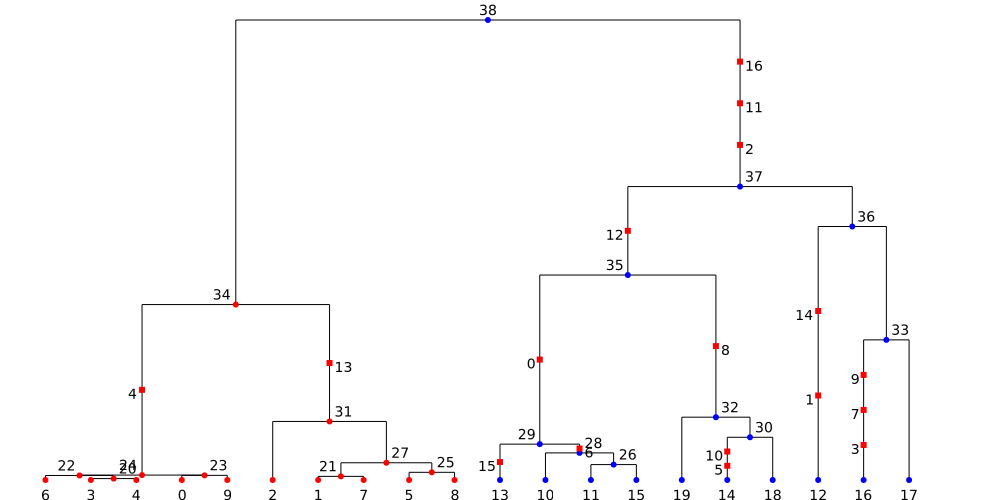

{'S_island': 2, 'S_meta': 12, 'pi_island': 0.001851851851851852, 'pi_meta': 0.0058888888888888906, 'dxy': 0.010833333333333332}


In [533]:
sequence_length = 600
mutation_rate = 3e-8
nsamps = 10

## This is the simple 2 population split model with constant population sizes
## just for getting the pi/dxy and sumstats functions tuned.
def two_pop_split_model(nsamps = nsamps, meta_Ne = 1e5, local_Ne = 2e4, mig = 0, tdiv=8e4, quiet=True):
    migmat = [[0, mig/local_Ne], [0, 0]]

    island_pop = msprime.PopulationConfiguration(sample_size=nsamps, initial_size=local_Ne)
    meta_pop = msprime.PopulationConfiguration(sample_size=nsamps, initial_size=meta_Ne)
    split_event = msprime.MassMigration(time=tdiv, source=0, destination=1, proportion=1)
    debug = msprime.DemographyDebugger(population_configurations=[island_pop, meta_pop], demographic_events=[split_event], migration_matrix=migmat)
    if not quiet: debug.print_history()

    tree_sequence = msprime.simulate(length=sequence_length,\
                                        migration_matrix=migmat,\
                                        mutation_rate=mutation_rate, \
                                        population_configurations=[island_pop, meta_pop],\
                                        demographic_events=[split_event])
    return tree_sequence

def plot_tree(tree_sequence, tfile="/tmp/tree.svg"):
    tree = tree_sequence.first()
    colour_map = {0:"red", 1:"blue"}
    node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
    tree.draw(path=tfile, height=500, width=1000, node_colours=node_colours)       
    display(SVG(tfile))

ts = two_pop_split_model()
plot_tree(ts)
stats = get_sumstats(ts)
print(stats)

In [104]:
def do_nsims(n = 100):
    stats_df = pd.DataFrame()
    for x in range(n):
        ts = two_pop_split_model()
        stats = get_sumstats(ts)
        df = pd.DataFrame(list(stats.values()), index=stats.keys())
        stats_df = pd.concat([stats_df, df], axis=1)
    return stats_df


stats_df = do_nsims(100)
mean_stats = stats_df.apply(np.mean, axis=1)
std_stats = stats_df.apply(np.std, axis=1)
display(mean_stats)
display(std_stats)

S_island      5.820000
S_meta       20.710000
pi_island     0.003445
pi_meta       0.012631
dxy           0.015917
dtype: float64

S_island     6.155290
S_meta       9.755301
pi_island    0.004486
pi_meta      0.006986
dxy          0.007697
dtype: float64

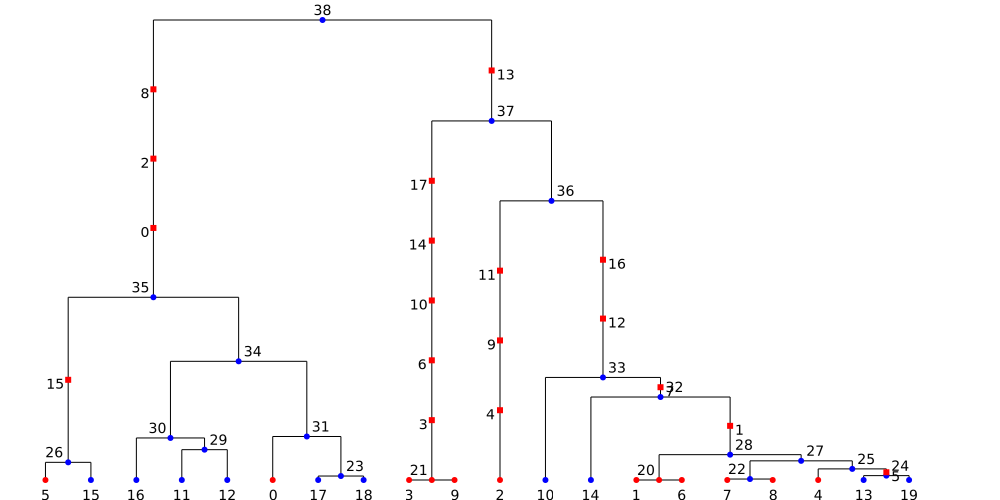

{'S_island': 17, 'S_meta': 10, 'pi_island': 0.010370370370370368, 'pi_meta': 0.0076296296296296294, 'dxy': 0.00986666666666667}


In [570]:
def get_random_sizechange_history():
    sims = glob.glob("/home/isaac/gimmeSAD/oldsims/1d_sims/*/pop_yoyos.txt")
    pops_file = np.random.choice(sims)
    def get_size_changes(pops_file):
        with open(pops_file) as pf:
            lines = pf.readlines()
            #line = lines[0]
            line = np.random.choice(lines)
        return line
    l = get_size_changes(pops_file)
    l = l.split("-")[1].strip()
    return np.array([n for n in ast.literal_eval(l)])

def harmonic_two_pop_split_model(sizes, nsamps = nsamps, meta_Ne = 1e5, local_Ne = 2e4, mig = 0, tdiv=8e4, quiet=True):
    migmat = [[0, mig/local_Ne], [0, 0]]

    island_pop = msprime.PopulationConfiguration(sample_size=nsamps, initial_size=local_Ne)
    meta_pop = msprime.PopulationConfiguration(sample_size=nsamps, initial_size=meta_Ne)
    size_change_events = []
    times = np.linspace(0, tdiv, len(sizes))
    ## pop_yoyos files record abundances backward in time from the present
    ## so this should be in the proper order for parameterizing size change for msprime
    for time, size in zip(times, sizes):
        island_size_change_event = msprime.PopulationParametersChange(time=time, initial_size=size, population_id=0)
        mig_rate_change_event = msprime.MigrationRateChange(time=time, matrix_index=(0,1), rate=mig/size)
        size_change_events.append(island_size_change_event)
        size_change_events.append(mig_rate_change_event)
    split_event = msprime.MassMigration(time=tdiv, source=0, destination=1, proportion=1)
    demo_events = [split_event]
    demo_events = size_change_events + demo_events
    tree_sequence = msprime.simulate(length=sequence_length,\
                                        migration_matrix=migmat,\
                                        mutation_rate=mutation_rate, \
                                        population_configurations=[island_pop, meta_pop],\
                                        demographic_events=demo_events)
    return tree_sequence
ts = harmonic_two_pop_split_model(sizes=[100, 200], mig=10)
plot_tree(ts)
stats = get_sumstats(ts)
print(stats)

## Run x number of simulations for harmonic mean pi/dxy horserace

In [ ]:
sigma = 1000
nsims = 1000

full_df = pd.DataFrame()
harm_df = pd.DataFrame()
for x in range(nsims):
    sizes = get_random_sizechange_history()
    ts = harmonic_two_pop_split_model(sizes*sigma, quiet=True)
    stats = get_sumstats(ts)
    df = pd.DataFrame(list(stats.values()), index=stats.keys())
    full_df = pd.concat([full_df, df], axis=1)
    
    sizes = hmean(np.array(sizes))
    ts = harmonic_two_pop_split_model([sizes*sigma], quiet=True)
    stats = get_sumstats(ts)
    df = pd.DataFrame(list(stats.values()), index=stats.keys())
    harm_df = pd.concat([harm_df, df], axis=1)
display(full_df.apply(np.mean, axis=1))
display(full_df.apply(np.std, axis=1))
display(harm_df.apply(np.mean, axis=1))
display(harm_df.apply(np.std, axis=1))

## Plot results

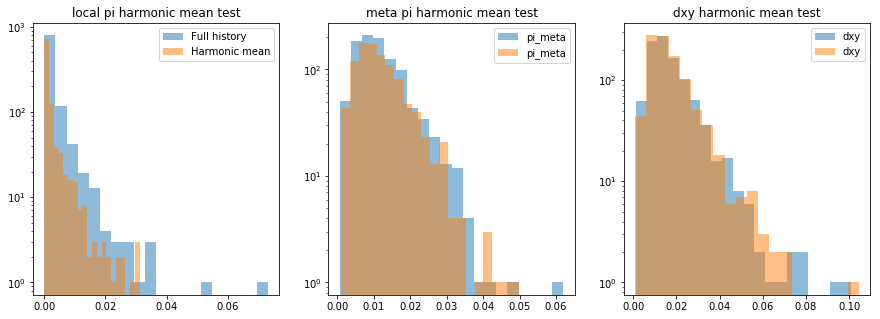

In [514]:
## local pi
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_, _, _ = axs[0].hist(full_df.loc["pi_island"], label="Full history", log=True, alpha=0.5, bins=20)
_, _, _ = axs[0].hist(harm_df.loc["pi_island"], label="Harmonic mean", log=True, alpha=0.5, bins=20)
axs[0].set_title("local pi harmonic mean test")
axs[0].legend()
## meta pi
_, _, _ = axs[1].hist(full_df.loc["pi_meta"], log=True, alpha=0.5, bins=20)
_, _, _ = axs[1].hist(harm_df.loc["pi_meta"], log=True, alpha=0.5, bins=20)
axs[1].set_title("meta pi harmonic mean test")
axs[1].legend()
## dxy
_, _, _ = axs[2].hist(full_df.loc["dxy"], log=True, alpha=0.5, bins=20)
_, _, _ = axs[2].hist(harm_df.loc["dxy"], log=True, alpha=0.5, bins=20)
axs[2].set_title("dxy harmonic mean test")
axs[2].legend()

## Plot pi correlation between full size change history and harmonic mean of size changes

(0, 0.04)

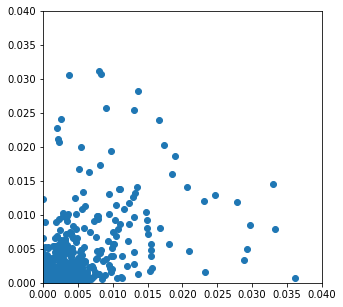

In [522]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(full_df.loc["pi_island"], harm_df.loc["pi_island"])
ax.set_ylim(0, 0.04)
ax.set_xlim(0, 0.04)

## Migration horserace

In [566]:
sigma = 1000
nsims = 200

migs_per_gen = [0, 0.001, 0.01, 0.1, 1, 10]
mig_dfs = {x:pd.DataFrame() for x in migs_per_gen}

for mig in migs_per_gen:
    for x in range(nsims):
        ts = two_pop_split_model(mig=mig)
        stats = get_sumstats(ts)
        df = pd.DataFrame(list(stats.values()), index=stats.keys())
        mig_dfs[mig] = pd.concat([mig_dfs[mig], df], axis=1)



S_island      6.590000
S_meta       19.690000
pi_island     0.003789
pi_meta       0.011776
dxy           0.015804
dtype: float64

S_island     7.428452
S_meta       9.780792
pi_island    0.004715
pi_meta      0.006901
dxy          0.008908
dtype: float64

S_island      5.665000
S_meta       19.950000
pi_island     0.003507
pi_meta       0.012008
dxy           0.016866
dtype: float64

S_island      5.571604
S_meta       10.303761
pi_island     0.004303
pi_meta       0.007334
dxy           0.009696
dtype: float64

S_island      5.735000
S_meta       20.320000
pi_island     0.003407
pi_meta       0.012224
dxy           0.017053
dtype: float64

S_island      6.001231
S_meta       10.503219
pi_island     0.004183
pi_meta       0.008211
dxy           0.010621
dtype: float64

S_island     10.06500
S_meta       19.65000
pi_island     0.00623
pi_meta       0.01123
dxy           0.01597
dtype: float64

S_island     7.983782
S_meta       9.438088
pi_island    0.005650
pi_meta      0.006263
dxy          0.008594
dtype: float64

S_island     17.165000
S_meta       20.435000
pi_island     0.010607
pi_meta       0.012150
dxy           0.012883
dtype: float64

S_island     10.066170
S_meta       10.084928
pi_island     0.007108
pi_meta       0.007150
dxy           0.007264
dtype: float64

S_island     20.040000
S_meta       19.595000
pi_island     0.011664
pi_meta       0.011354
dxy           0.011682
dtype: float64

S_island     10.440709
S_meta        9.357936
pi_island     0.006592
pi_meta       0.006462
dxy           0.006455
dtype: float64

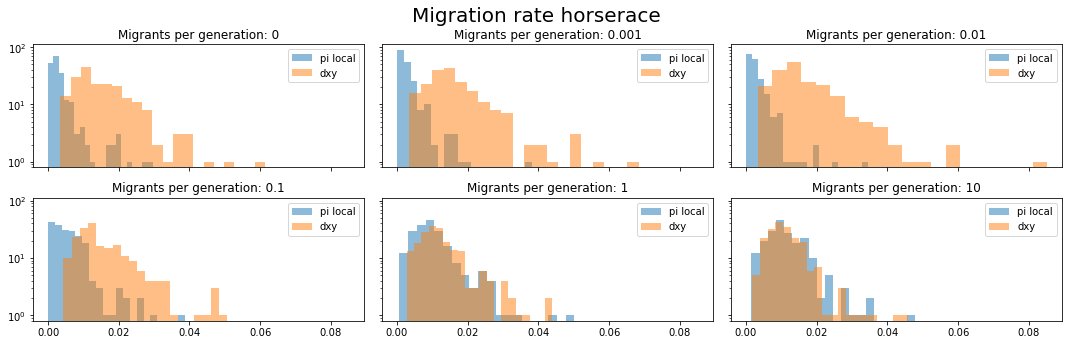

In [575]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5), sharex=True, sharey=True)
axs = [x for y in axs for x in y]
for mig, ax in zip(migs_per_gen, axs):
    _, _, _ = ax.hist(mig_dfs[mig].loc["pi_island"], label="pi local", log=True, alpha=0.5, bins=20)
    _, _, _ = ax.hist(mig_dfs[mig].loc["dxy"], label="dxy", log=True, alpha=0.5, bins=20)
    ax.set_title("Migrants per generation: {}".format(mig))
    ax.legend()
_ = plt.suptitle("Migration rate horserace", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Migration horserace with fluctuating population sizes

In [ ]:
sigma = 1000
nsims = 1000

def sim_mig_with_sizes():
    migs_per_gen = [0, 0.001, 0.01, 0.1, 1, 10]
    fluc_mig_dfs = {x:pd.DataFrame() for x in migs_per_gen}
    harm_mig_dfs = {x:pd.DataFrame() for x in migs_per_gen}

    for mig in migs_per_gen:
        print("Doing migrate: {}".format(mig))
        for x in range(nsims):
            sizes = get_random_sizechange_history()
            ts = harmonic_two_pop_split_model(sizes*sigma, mig=mig)
            stats = get_sumstats(ts)
            df = pd.DataFrame(list(stats.values()), index=stats.keys())
            fluc_mig_dfs[mig] = pd.concat([fluc_mig_dfs[mig], df], axis=1)

            sizes = hmean(np.array(sizes))
            ts = harmonic_two_pop_split_model([sizes*sigma], mig=mig)
            stats = get_sumstats(ts)
            df = pd.DataFrame(list(stats.values()), index=stats.keys())
            harm_mig_dfs[mig] = pd.concat([harm_mig_dfs[mig], df], axis=1)
    return fluc_mig_dfs, harm_mig_dfs

fluc_mig_dfs, harm_mig_dfs = sim_mig_with_sizes()

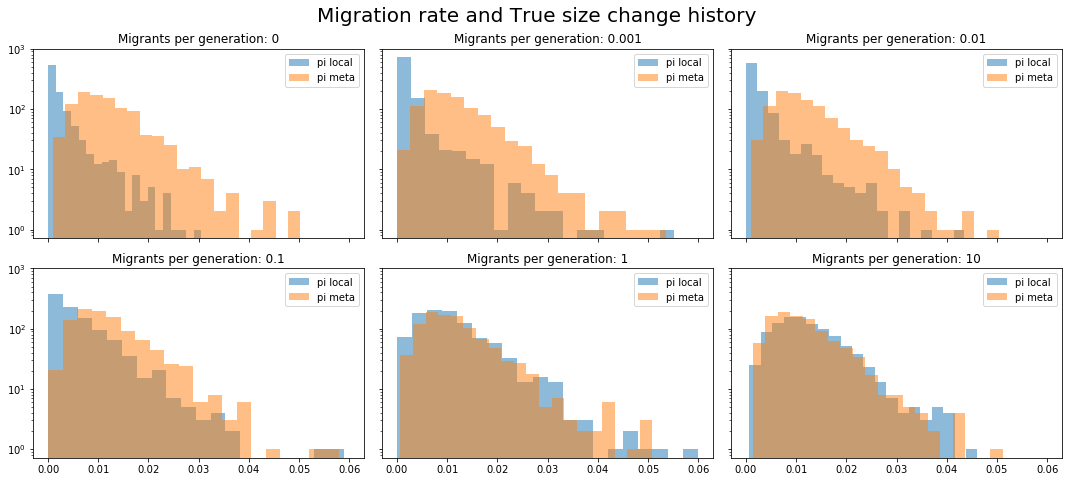

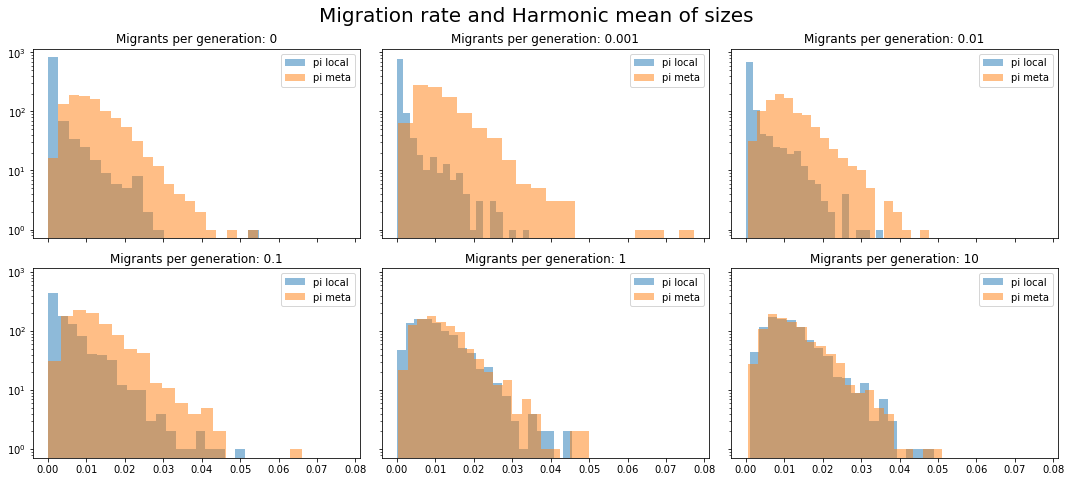

In [583]:
for df, title in zip([fluc_mig_dfs, harm_mig_dfs], ["True size change history", "Harmonic mean of sizes"]):
    fig, axs = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)
    axs = [x for y in axs for x in y]
    for mig, ax in zip(migs_per_gen, axs):
        _, _, _ = ax.hist(df[mig].loc["pi_island"], label="pi local", log=True, alpha=0.5, bins=20)
        _, _, _ = ax.hist(df[mig].loc["pi_meta"], label="pi meta", log=True, alpha=0.5, bins=20)
        _, _, _ = ax.hist(df[mig].loc["dxy"], label="dxy", log=True, alpha=0.5, bins=20)
        ax.set_title("Migrants per generation: {}".format(mig))
        ax.legend()
    _ = plt.suptitle("Migration rate and {}".format(title), fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

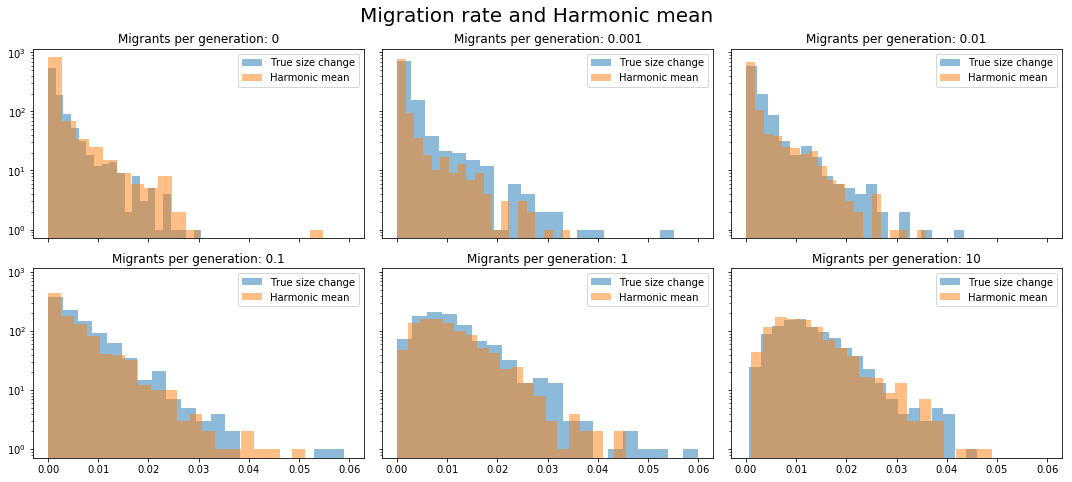

In [584]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7), sharex=True, sharey=True)
axs = [x for y in axs for x in y]
for mig, ax in zip(migs_per_gen, axs):
    for df, title in zip([fluc_mig_dfs, harm_mig_dfs], ["True size change", "Harmonic mean"]):
        _, _, _ = ax.hist(df[mig].loc["pi_island"], label=title, log=True, alpha=0.5, bins=20)
    ax.set_title("Migrants per generation: {}".format(mig))
    ax.legend()
_ = plt.suptitle("Migration rate and {}".format(title), fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Everything is junk below here

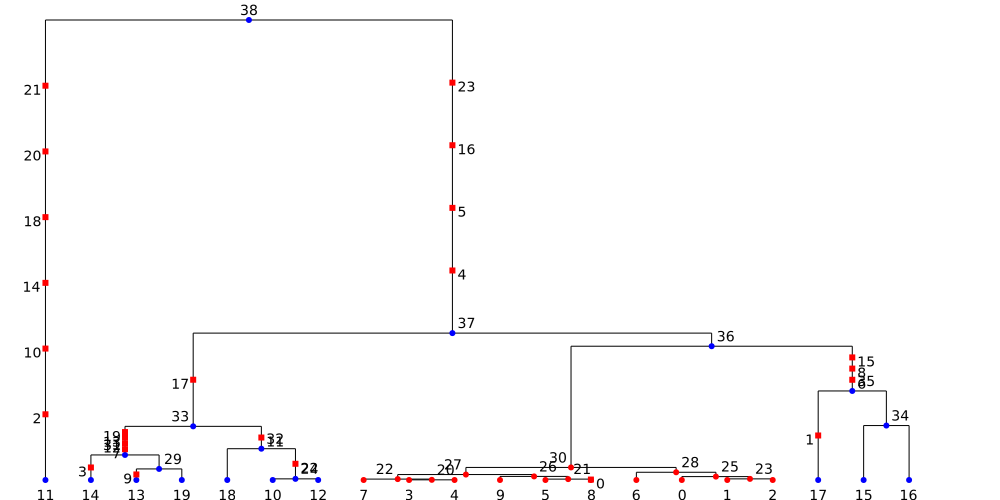

{'S_island': 1,
 'S_meta': 23,
 'dxy': 0.0076666666666666645,
 'pi_island': 0.0003333333333333334,
 'pi_meta': 0.01203703703703704}

In [463]:
sizes = get_random_sizechange_history()
sigma=1000
sizes = hmean(np.array(sizes))
ts = harmonic_two_pop_split_model([sizes*sigma], quiet=True)
plot_tree(ts)
stats = get_sumstats(ts)
stats

In [433]:
sigma = 1000
def do_harmonic_nsims(n = 100):
    stats_df = pd.DataFrame()
    for x in range(n):
        sizes = get_random_sizechange_history()

        ts = harmonic_two_pop_split_model(sizes*sigma)
        stats = get_sumstats(ts)
        df = pd.DataFrame(list(stats.values()), index=stats.keys())
        stats_df = pd.concat([stats_df, df], axis=1)
    return stats_df


stats_df = do_harmonic_nsims(20)
mean_stats = stats_df.apply(np.mean, axis=1)
std_stats = stats_df.apply(np.std, axis=1)
display("mean", mean_stats)
display("std", std_stats)



'mean'

S_island      7.600000
S_meta       16.300000
pi_island     0.003617
pi_meta       0.009707
dxy           0.012720
dtype: float64

'std'

S_island     12.026637
S_meta        6.679072
pi_island     0.006261
pi_meta       0.003630
dxy           0.004639
dtype: float64

In [526]:
times = np.linspace(0, 1e4, len([1]))
times

array([ 0.])